# Analisis Data Nasabah Bank Untuk Marketing Campaign

###Business Problem

**CONTEXT:**
Sebuah perusahaan perbankan Portugis sedang melakukan campaign untuk meningkatkan jumlah nasabah agar mau melakukan deposito berjangka di bank nya. Kampanye ini dilakukan melalui panggilan telepon untuk menawarkan produk Deposito Berjangka kepada nasabah. Namun, tidak semua nasabah yang dihubungi tertarik untuk membuka deposito. Bank ingin meningkatkan efisien dalam pelaksanaan campaign tersebut agar tidak membuang banyak waktu , tenaga, dan uang. Maka dari itu bank ingin menargetkan calon depositor yang kemungkinan besar mau untuk menerima tawaran bank tersebut. Bank memiliki data historis yang mencakup demografi nasabah (usia, pekerjaan, status), kondisi finansial (saldo, pinjaman), serta riwayat interaksi sebelumnya.

Target :

0 (No): Nasabah tidak setuju untuk berlangganan deposito.

1 (Yes): Nasabah setuju untuk berlangganan deposito.

**Problem Statement**

Proses pemasaran melalui telemarketing sangat memakan biaya operasional (gaji staf, biaya telepon) dan waktu. Jika bank menghubungi semua nasabah secara acak tanpa penyaringan, tingkat kegagalan akan tinggi, yang mengakibatkan pemborosan sumber daya dan potensi penurunan kepuasan nasabah akibat gangguan telepon yang tidak relevan. Bank memerlukan cara untuk membedakan antara nasabah yang memiliki niat menabung dengan yang tidak, sebelum panggilan dilakukan.

**Goals**

Berdasarkan permasalahan tersebut, proyek ini memiliki dua tujuan utama:

Kemampuan Prediksi: Membangun model yang dapat memprediksi probabilitas seorang nasabah akan berlangganan deposito, sehingga tim pemasaran dapat memprioritaskan nasabah dengan potensi konversi tertinggi.

Identifikasi Faktor Kunci: Mengetahui variabel atau karakteristik apa (misalnya durasi telefon, jenis pekerjaan, atau saldo) yang paling memengaruhi keputusan nasabah, sehingga bank dapat merancang skrip penawaran atau strategi pemasaran yang lebih tepat sasaran.

**Analytic Approach**

Pendekatan yang dilakukan adalah dengan melakukan Analisis Data Eksploratif (EDA) untuk mengidentifikasi pola perilaku nasabah yang sukses dikonversi pada kampanye sebelumnya. Selanjutnya, data akan diproses (preprocessing) agar siap digunakan dalam membangun beberapa Model Klasifikasi (seperti Logistic Regression, Random Forest, atau Decision Tree). Model-model ini akan diuji untuk melihat kemampuannya dalam membedakan kelas "Yes" dan "No" secara akurat.

**Metric Evaluation**

Dalam kasus ini, terdapat dua jenis kesalahan prediksi dengan konsekuensi yang berbeda:

Type 1 Error (False Positive):

Prediksi: Nasabah diprediksi akan berlangganan, namun Kenyataannya tidak.

Konsekuensi: Pemborosan biaya operasional (telepon dan waktu staf) untuk nasabah yang tidak menghasilkan keuntungan.

Type 2 Error (False Negative):

Prediksi: Nasabah diprediksi tidak akan berlangganan, namun Kenyataannya sebenarnya dia mau.

Konsekuensi: Kehilangan peluang keuntungan (opportunity loss) dari deposito yang seharusnya bisa didapatkan.

**Fokus Metrik**

Karena tujuan utama perusahaan adalah mencari sebanyak mungkin nasabah potensial dan tidak begitu masalah dengan calon nasabah yang sebenarnya tidak tertarik tetapi tetap kita tawarkan, maka kita menggunakan Recall.  Metrik ini akan menunjukkan seberapa baik model mampu membedakan antara kedua kelas (Yes/No) di berbagai ambang batas keputusan, sehingga bank dapat menentukan titik optimal antara penghematan biaya dan perolehan laba.

##Data Understanding

Dataset Source: https://www.kaggle.com/datasets/krantiswalke/bankfullcsv


Note:


*   Dataset sangat tidak seimbang
*   Dataset ini merupakan kombinasi dari fitur numerik dan kategorikal, dengan dominasi pada fitur kategorikal.
* Kardinalitas cenderungg medium



Tantangan khusus:
* Fitur duration (Data Leakage): Kolom ini menunjukkan lama telepon. Masalahnya, durasi baru diketahui setelah telepon dilakukan. Jika durasi = 0, maka y pasti "no". Untuk model prediksi yang realistis sebelum menelepon, fitur ini sebenarnya sering kali harus dihapus atau dianulir karena menyebabkan leakage.

* Nilai "Unknown": Banyak kolom seperti job, education, contact, dan poutcome memiliki nilai "unknown". Ini bukan missing value (NaN) secara teknis, tapi secara substansi adalah data yang hilang yang perlu ditangani (apakah mau dianggap sebagai kategori sendiri atau diisi dengan modus).

* Korelasi Temporal: Adanya kolom day dan month menunjukkan adanya efek musiman. Strategi penanganan kolom month (apakah menjadi angka 1-12 atau One-Hot Encoding) akan sangat memengaruhi performa model.

### Import Librarries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import metrics
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
%matplotlib inline

##load dataset

In [3]:
bank=pd.read_csv("bank-full.csv")
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## shape of the data

In [4]:
bank.shape

(45211, 17)

## Attribute information

In [5]:
bank.dtypes

,0
age,int64
job,object
marital,object
education,object
default,object
balance,int64
housing,object
loan,object
contact,object
day,int64


In [6]:
bank.rename(columns={'y':'Target'}, inplace=True)
bank.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no


### Pengecekan apakah ada missing value

In [7]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  Target     45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


### Numerical Atribute

In [8]:
bank.describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


### Pengecekan untuk class imbalance

In [9]:
no,yes=bank.Target.value_counts()
bank.Target.value_counts()

,count
Target,
no,39922
yes,5289


Dataset ini sangat imbalance, kategori 'no' sangat jauh tinggi dibandingkan kategori 'yes'.

In [10]:
bank['Target'].value_counts(normalize=True)

,proportion
Target,
no,0.883015
yes,0.116985


Tingkat respons hanya 11,6%. Oleh karena itu, variabel Y (Target) memiliki class imbalance yang tinggi. Dengan demikian, akurasi bukanlah ukuran kinerja model yang dapat diandalkan.

FN sangat penting untuk kasus bisnis ini karena false negative adalah pelanggan yang berpotensi berlangganan pinjaman tetapi telah diklasifikasikan sebagai 'tidak akan berlangganan'. Oleh karena itu, ukuran kinerja model yang paling relevan adalah recall.

###Pengecekan Outliers

<Axes: ylabel='age'>

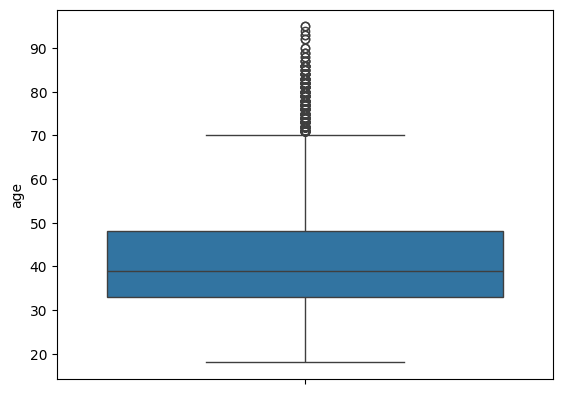

In [11]:
sns.boxplot(bank.age)

Terlihat bahwa terdapat beberapa outliers. Dan rata-rata dari umurnya sekitar 39 tahun. Ada juga customer yang berusia diatas 90 tahun. Data ini harus di check untuk di hilangkan outliers nya.

In [12]:
# Quartiles
print('1º Quartile: ', bank['age'].quantile(q = 0.25))
print('2º Quartile: ', bank['age'].quantile(q = 0.50))
print('3º Quartile: ', bank['age'].quantile(q = 0.75))
print('4º Quartile: ', bank['age'].quantile(q = 1.00))
#Calculate the outliers:
  # Interquartile range, IQR = Q3 - Q1
  # lower 1.5*IQR whisker = Q1 - 1.5 * IQR
  # Upper 1.5*IQR whisker = Q3 + 1.5 * IQR

print('Umur diatas: ', bank['age'].quantile(q = 0.75) +
                      1.5*(bank['age'].quantile(q = 0.75) - bank['age'].quantile(q = 0.25)), 'adalah outliers')

1º Quartile:  33.0
2º Quartile:  39.0
3º Quartile:  48.0
4º Quartile:  95.0
Umur diatas:  70.5 adalah outliers


In [13]:
print('Jumlah dari outliers adalah: ',bank[bank['age']>70.5]['age'].count())
print('Jumlah dari baris adalah: ',len(bank))
#outlier dalam %
print('Jumlah persen dari outliers adalah: ', round(bank[bank['age'] > 70.5]['age'].count()*100/len(bank),2),'%')

Jumlah dari outliers adalah:  487
Jumlah dari baris adalah:  45211
Jumlah persen dari outliers adalah:  1.08 %


For duration

/usr/local/lib/python3.12/dist-packages/seaborn/_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/tmp/ipython-input-2539561110.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(bank['duration'], ax = ax2)


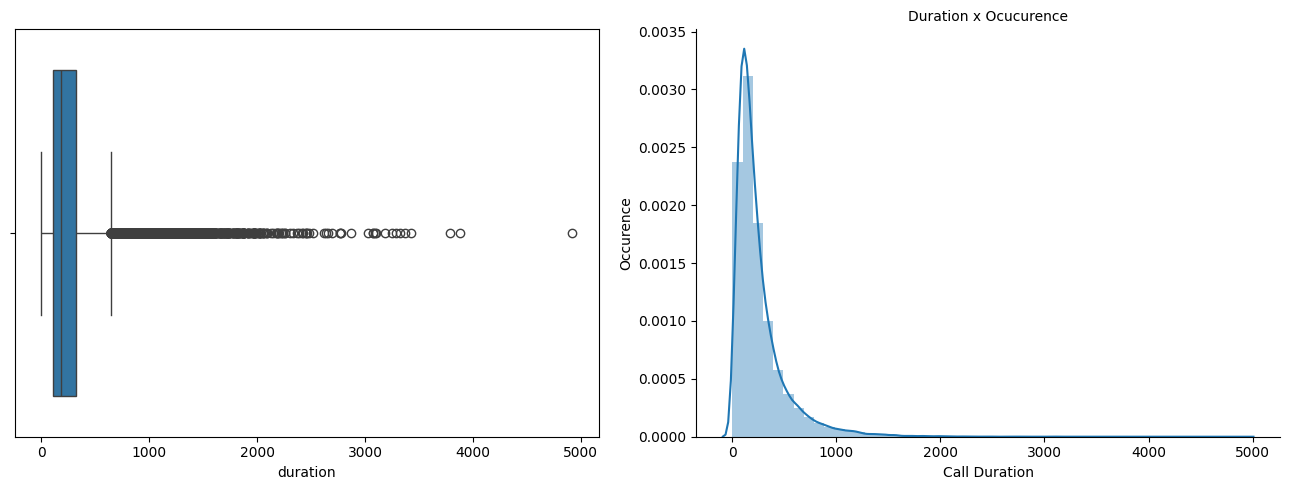

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))
sns.boxplot(x = 'duration', data = bank, orient = 'v', ax = ax1)
ax1.tick_params(labelsize=10)

sns.distplot(bank['duration'], ax = ax2)
sns.despine(ax = ax2)
ax2.set_xlabel('Call Duration', fontsize=10)
ax2.set_ylabel('Occurence', fontsize=10)
ax2.set_title('Duration x Ocucurence', fontsize=10)
ax2.tick_params(labelsize=10)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout()

In [15]:
print("Max duration  call in minutes:  ", round((bank['duration'].max()/60),1))
print("Min duration  call in minutes:   ", round((bank['duration'].min()/60),1))
print("Mean duration call in minutes:   ", round((bank['duration'].mean()/60),1))
print("STD dev of duration  call in minutes:   ", round((bank['duration'].std()/60),1))
# Std dekat dengan rata-rata berarti data values dekat dengan rata-rata

Max duration  call in minutes:   82.0
Min duration  call in minutes:    0.0
Mean duration call in minutes:    4.3
STD dev of duration  call in minutes:    4.3


In [16]:
# Quartiles
print('1º Quartile: ', bank['duration'].quantile(q = 0.25))
print('2º Quartile: ', bank['duration'].quantile(q = 0.50))
print('3º Quartile: ', bank['duration'].quantile(q = 0.75))
print('4º Quartile: ', bank['duration'].quantile(q = 1.00))
#Menghitung outliers:
  # Interquartile range, IQR = Q3 - Q1
  # lower 1.5*IQR whisker = Q1 - 1.5 * IQR
  # Upper 1.5*IQR whisker = Q3 + 1.5 * IQR

print('Durasi call diatas: ', bank['duration'].quantile(q = 0.75) +
                      1.5*(bank['duration'].quantile(q = 0.75) - bank['duration'].quantile(q = 0.25)), 'adalah outliers')


1º Quartile:  103.0
2º Quartile:  180.0
3º Quartile:  319.0
4º Quartile:  4918.0
Durasi call diatas:  643.0 adalah outliers


In [17]:
print('Numerber of outliers: ', bank[bank['duration'] > 644.5]['duration'].count())
print('Number of rows: ', len(bank))
#Outliers in %
print('Outliers are:', round(bank[bank['duration'] > 644.5]['duration'].count()*100/len(bank),2), '%')

Numerber of outliers:  3222
Number of rows:  45211
Outliers are: 7.13 %


In [18]:
# Kalau durasi call  adalah sama dengan 0, maka sudah di pastikan orang tersebut tidak subscribe,
# THIS LINES NEED TO BE DELETED LATER
bank[(bank['duration'] == 0)]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
6424,53,management,married,primary,no,351,yes,no,unknown,27,may,0,4,-1,0,unknown,no
22937,35,technician,married,secondary,no,5535,no,no,cellular,26,aug,0,15,-1,0,unknown,no
36425,31,entrepreneur,married,secondary,no,162,yes,yes,cellular,11,may,0,2,-1,0,unknown,no


In [19]:
bank=bank[(bank['duration'] != 0)]

###Plots

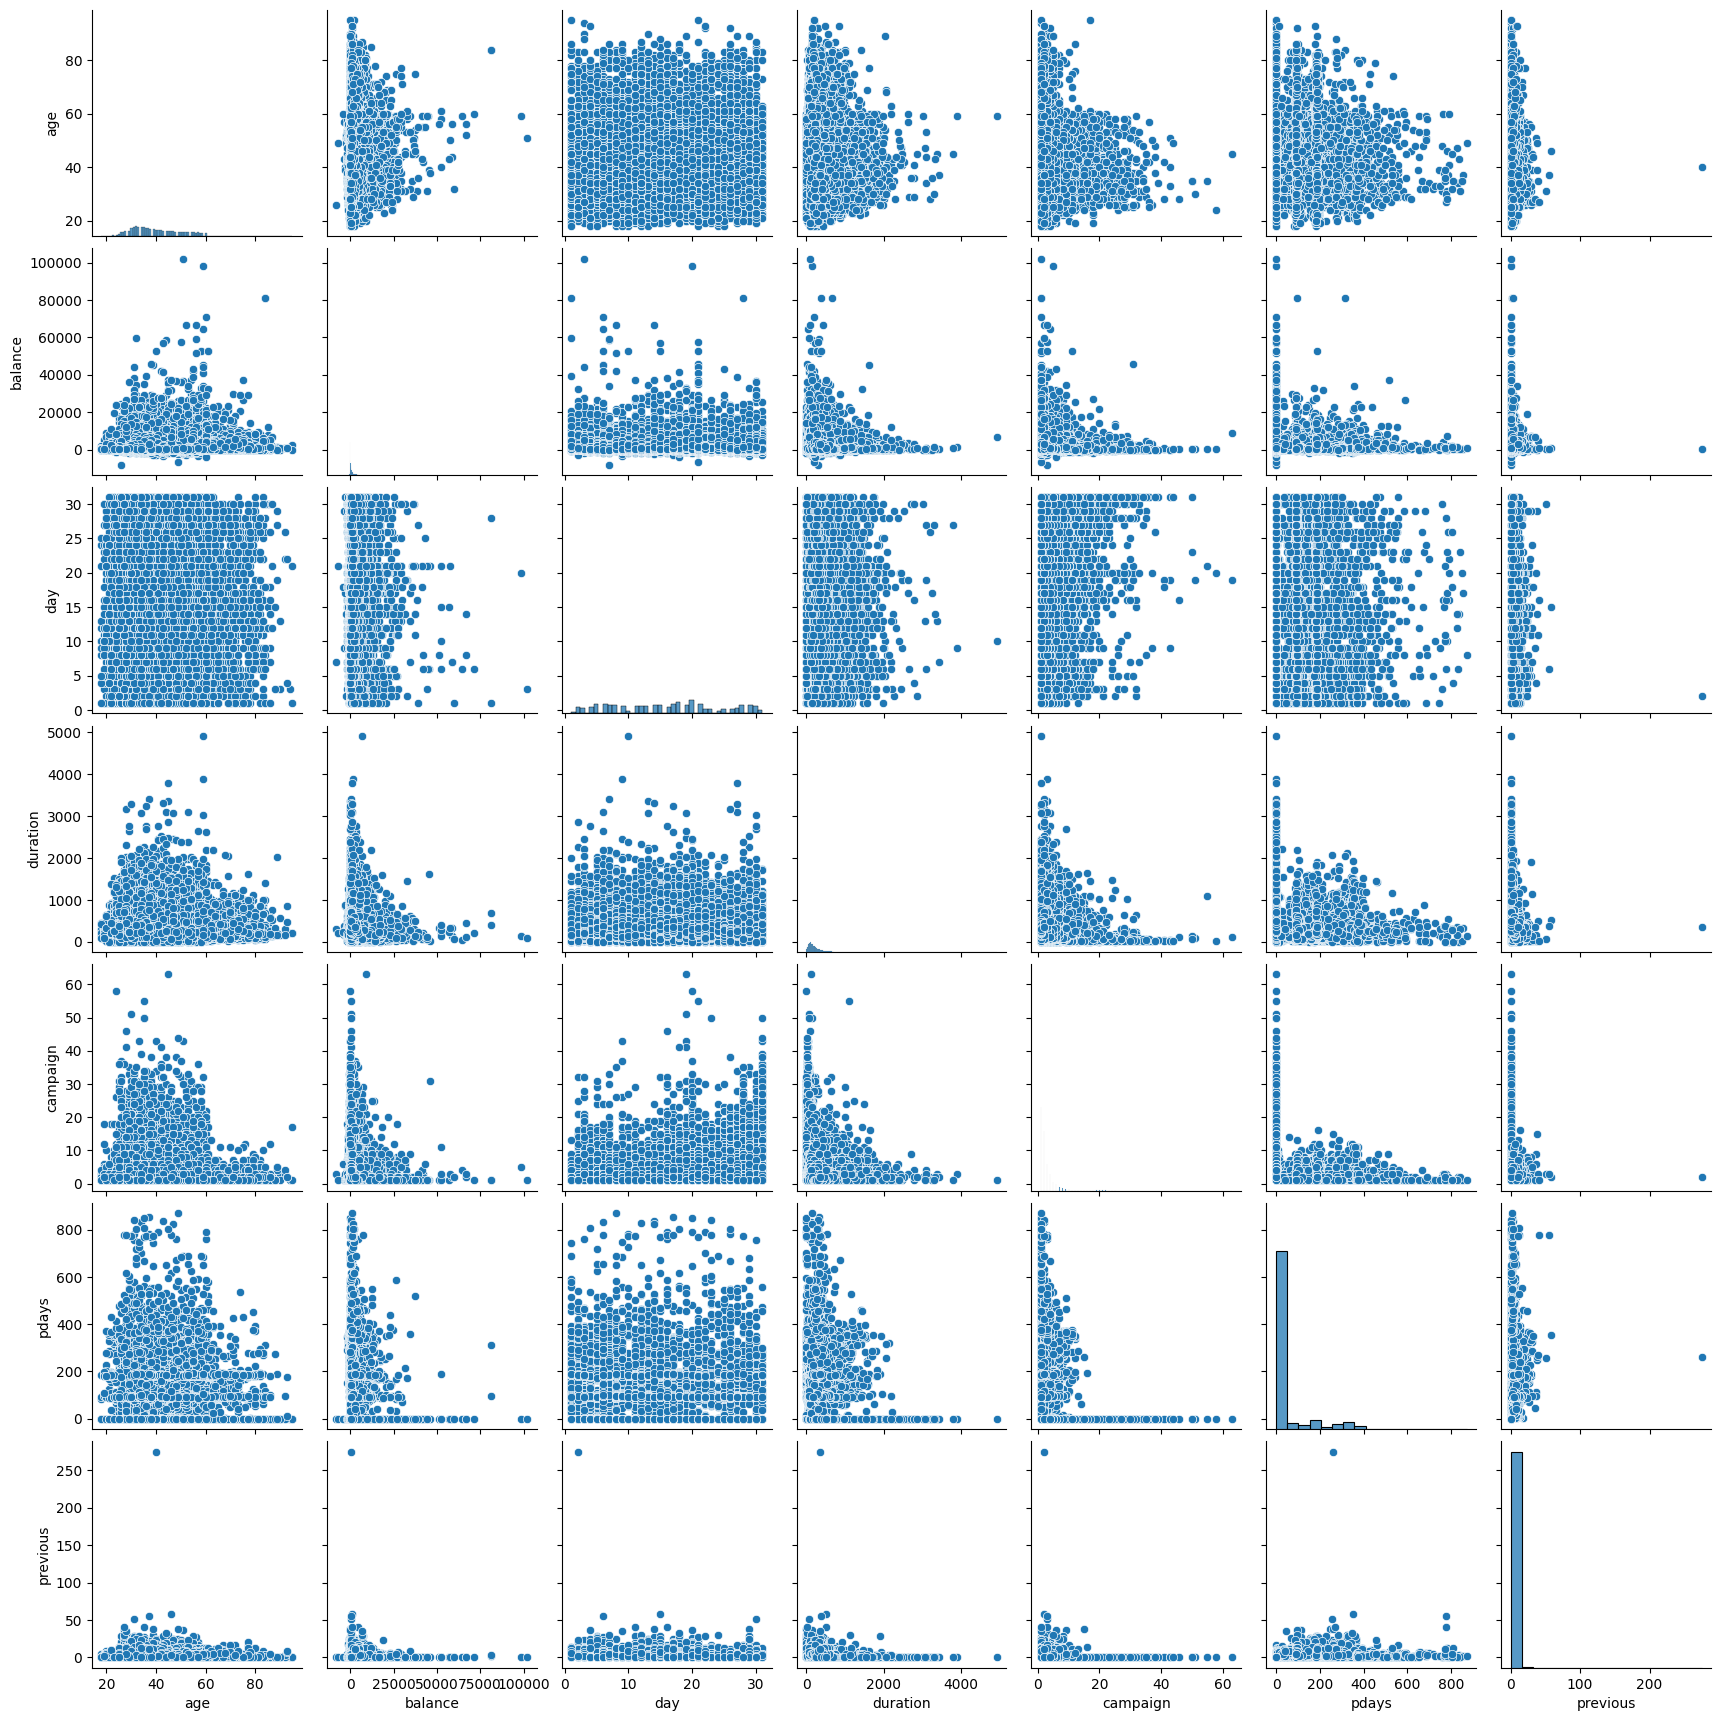

In [20]:
sns.pairplot(bank)

In [21]:
bank_numeric = bank.select_dtypes(include='number')

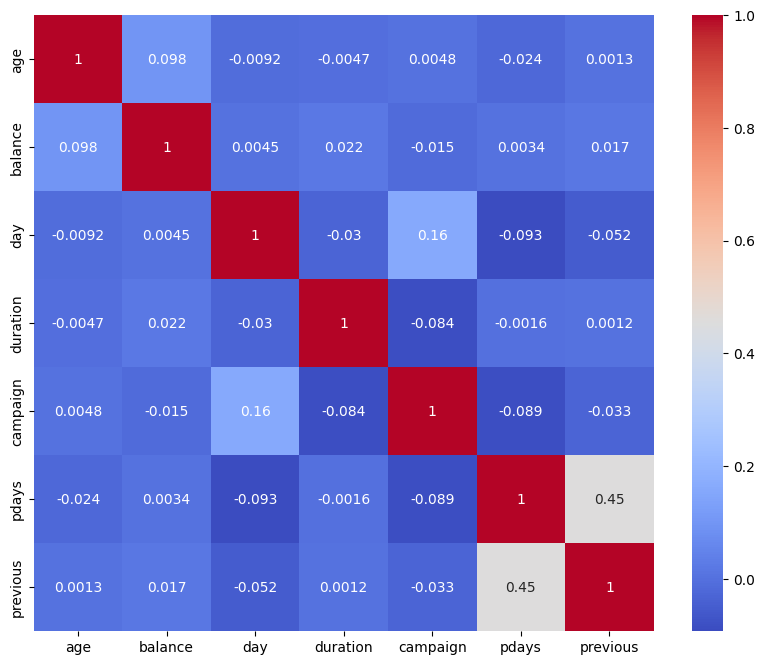

In [22]:
plt.figure(figsize=(10,8))
sns.heatmap(bank_numeric.corr(), annot=True, cmap='coolwarm')
plt.show()

Distribusi semua variabel numerik selain usia sangat tidak simetris, oleh karena itu kita perlu mentransformasi atau mengelompokkan beberapa variabel ini.

Dengan cara yang sama, kita akan melakukan univariate analysis pada variabel numerik lainnya.

###Univariate Analysis / Value Count Untuk Categorical Variables

In [23]:
bank['job'].value_counts()

,count
job,
blue-collar,9732
management,9457
technician,7596
admin.,5171
services,4154
retired,2264
self-employed,1579
entrepreneur,1486
unemployed,1303


<Axes: xlabel='count', ylabel='marital'>

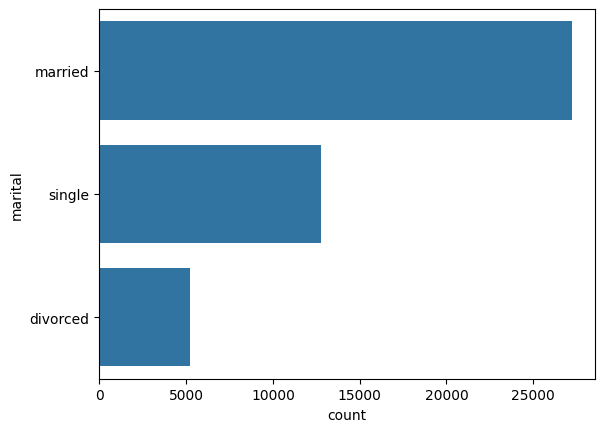

In [24]:
sns.countplot(bank['marital'])

<Axes: xlabel='count', ylabel='education'>

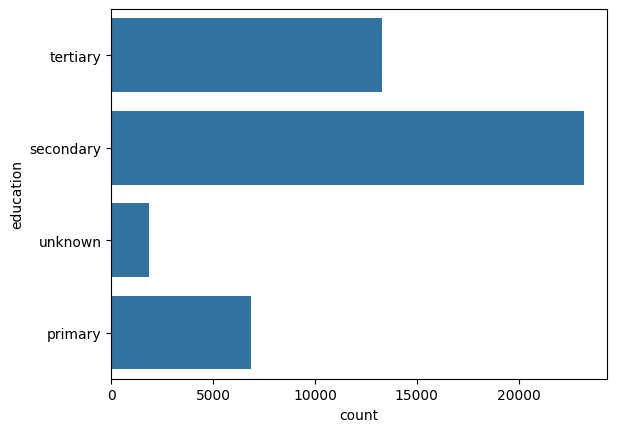

In [25]:
sns.countplot(bank['education'])

<Axes: xlabel='count', ylabel='default'>

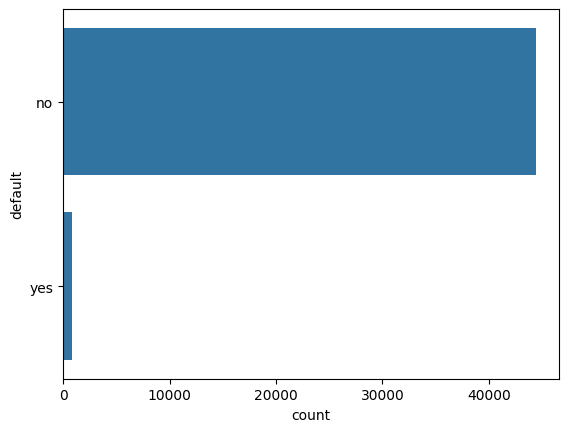

In [26]:
sns.countplot(bank['default'])

<Axes: xlabel='count', ylabel='housing'>

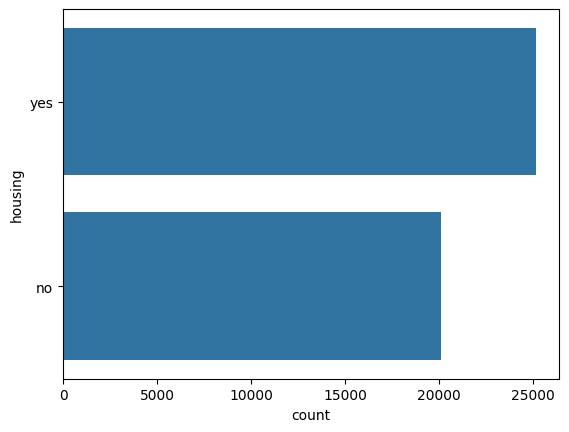

In [27]:
sns.countplot(bank['housing'])

<Axes: xlabel='count', ylabel='loan'>

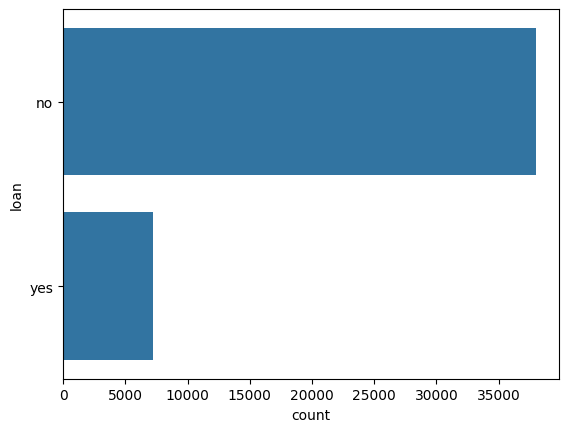

In [28]:
sns.countplot(bank['loan'])

<Axes: xlabel='count', ylabel='contact'>

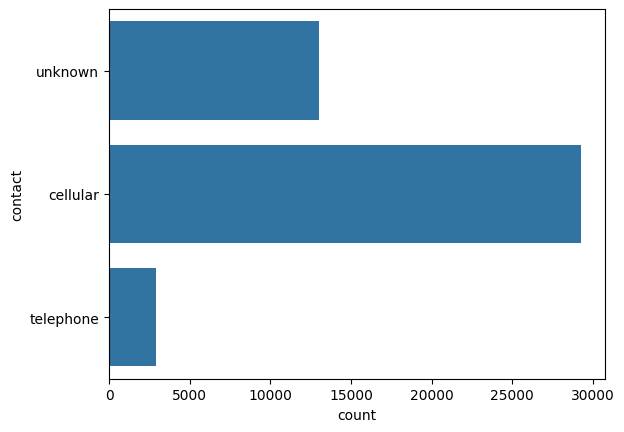

In [29]:
sns.countplot(bank['contact'])

<Axes: xlabel='count', ylabel='poutcome'>

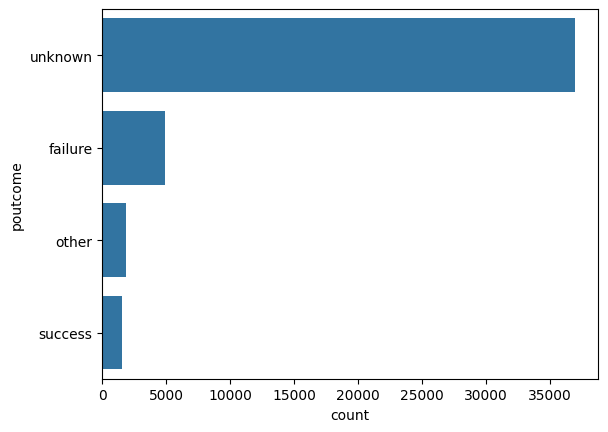

In [30]:
sns.countplot(bank['poutcome'])

<Axes: xlabel='count', ylabel='Target'>

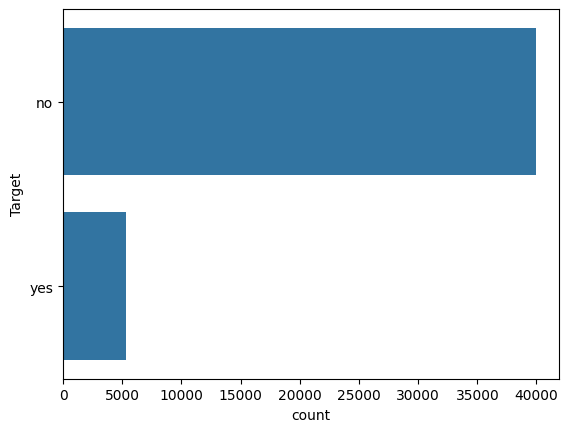

In [31]:
sns.countplot(bank['Target'])

###Bivariate Analysis

In [32]:
np.round(
    bank.groupby("Target").mean(numeric_only=True),
    1
)


,age,balance,day,duration,campaign,pdays,previous
Target,,,,,,,
no,40.8,1303.7,15.9,221.2,2.8,36.4,0.5
yes,41.7,1804.3,15.2,537.3,2.1,68.7,1.2


Pelanggan yang berlangganan, rata-rata saldonya lebih tinggi dibandingkan dengan mereka yang tidak berlangganan.

Jumlah hari yang berlalu setelah klien terakhir dihubungi dari kampanye sebelumnya lebih tinggi untuk orang yang telah berlangganan.

Jumlah kontak yang dilakukan sebelum kampanye ini juga lebih tinggi untuk pelanggan yang berlangganan.

Semua fakta di atas menunjukkan bahwa pelanggan dengan saldo lebih tinggi dan mereka yang telah sering dihubungi sebelum kampanye cenderung berlangganan deposito berjangka.

###Bivariate analysis menggunakan Crosstab

In [33]:
pd.crosstab(bank['job'], bank['Target'], normalize='index').sort_values(by='yes',ascending=False)

Target,no,yes
job,,
student,0.713220,0.286780
retired,0.772085,0.227915
unemployed,0.844973,0.155027
management,0.862430,0.137570
admin.,0.877973,0.122027
self-employed,0.881571,0.118429
unknown,0.881944,0.118056
technician,0.889415,0.110585
services,0.911170,0.088830


Yang paling tinggi adalah mahasiswa untuk 28% dan terendah adalah pekerja blue collar (buruh pabrik, sopir truk, dll) yaitu sebesar 7%

In [34]:
pd.crosstab(bank['marital'], bank['Target'], normalize='index').sort_values(by='yes',ascending=False)

Target,no,yes
marital,,
single,0.850508,0.149492
divorced,0.880545,0.119455
married,0.898754,0.101246


In [35]:
pd.crosstab(bank['education'], bank['Target'], normalize='index').sort_values(by='yes',ascending=False)

Target,no,yes
education,,
tertiary,0.849936,0.150064
unknown,0.864297,0.135703
secondary,0.894397,0.105603
primary,0.913723,0.086277


In [36]:
print(pd.crosstab(bank['default'], bank['Target'], normalize='index').sort_values(by='yes',ascending=False))
print(bank['default'].value_counts(normalize=True))

Target         no       yes
default                    
no       0.882031  0.117969
yes      0.936196  0.063804
default
no     0.981972
yes    0.018028
Name: proportion, dtype: float64


In [37]:
pd.crosstab(bank['housing'], bank['Target'], normalize='index').sort_values(by='yes',ascending=False)

Target,no,yes
housing,,
no,0.832968,0.167032
yes,0.922994,0.077006


In [38]:
pd.crosstab(bank['loan'], bank['Target'], normalize='index').sort_values(by='yes',ascending=False)

Target,no,yes
loan,,
no,0.873436,0.126564
yes,0.933177,0.066823


In [39]:
pd.crosstab(bank['contact'], bank['Target'], normalize='index').sort_values(by='yes',ascending=False)

Target,no,yes
contact,,
cellular,0.850801,0.149199
telephone,0.865795,0.134205
unknown,0.959290,0.040710


In [40]:
pd.crosstab(bank['month'], bank['Target'], normalize='index').sort_values(by='yes',ascending=False)

Target,no,yes
month,,
mar,0.480084,0.519916
dec,0.532710,0.467290
sep,0.535406,0.464594
oct,0.562331,0.437669
apr,0.803206,0.196794
feb,0.833522,0.166478
aug,0.889850,0.110150
jun,0.897772,0.102228
nov,0.898489,0.101511


###Listing hasil dari analisis bivariat yang dapat memberikan petunjuk untuk pemilihan fitur.

In [41]:
#pengelompokan
def binning(col, cut_points, labels=None):
  minval = col.min()
  maxval = col.max()
  #membuat list dengan menambahkan min dan max ke cut_points
  break_points = [minval] + cut_points + [maxval]
  if not labels:
    labels = range(len(cut_points)+1)
  #mengelompokan menggunakan cut function dari pandas
  colBin = pd.cut(col, bins=break_points, labels=labels, include_lowest=True)
  return colBin

In [42]:
#pengelompokan campaign
cut_points = [2, 3, 4,]
labels = ["<=2", "3", "4", ">4"]
bank['campaign_range'] = binning(bank['campaign'], cut_points, labels)
bank['campaign_range'].value_counts()

,count
campaign_range,
<=2,30048
>4,6118
3,5521
4,3521


In [43]:
bank.drop(['campaign'], axis=1, inplace=True)
bank.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'pdays', 'previous',
       'poutcome', 'Target', 'campaign_range'],
      dtype='object')

In [44]:
#function untuk membuat grup dari umur
def age(dataframe):
  dataframe.loc[dataframe['age']<=32, 'age'] = 1
  dataframe.loc[(dataframe['age']>32) & (dataframe['age']<=47), 'age'] = 2
  dataframe.loc[dataframe['age']>47 & (dataframe['age']<=70), 'age'] = 3
  dataframe.loc[dataframe['age']>70 & (dataframe['age']<=98), 'age'] = 4
  return dataframe
age(bank);

In [45]:
def duration(data):

    data.loc[data['duration'] <= 102, 'duration'] = 1
    data.loc[(data['duration'] > 102) & (data['duration'] <= 180)  , 'duration']    = 2
    data.loc[(data['duration'] > 180) & (data['duration'] <= 319)  , 'duration']   = 3
    data.loc[(data['duration'] > 319) & (data['duration'] <= 644.5), 'duration'] = 4
    data.loc[data['duration']  > 644.5, 'duration'] = 5

    return data
duration(bank);

###Split Data Ke Train/Test

In [46]:
x = bank.drop(['Target'], axis=1)
y = bank['Target']
x = pd.get_dummies(x,drop_first=True)
y=y.replace(['yes','no'],[1,0])

/tmp/ipython-input-1111030473.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y=y.replace(['yes','no'],[1,0])


In [47]:
test_size = 0.30
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

#####Apply beberapa models dengan fitting train data

###Decision Tree Classifier

[[11101   904]
 [  822   736]]
87.0


<Axes: >

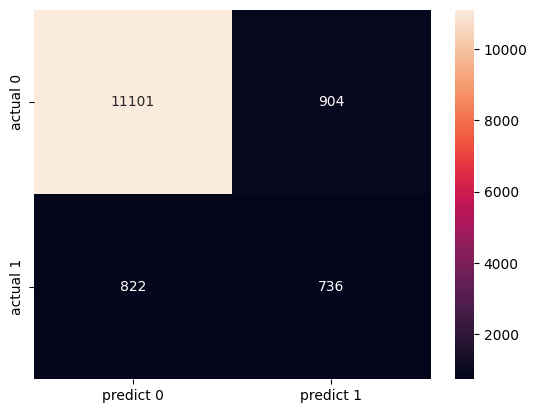

In [48]:

dtree = DecisionTreeClassifier(criterion='gini',random_state=1)
dtree.fit(x_train, y_train)
dtreepred = dtree.predict(x_test)

cm=confusion_matrix(y_test, dtreepred)
print(cm)
print(round(accuracy_score(y_test, dtreepred),2)*100)
sns.heatmap(cm,annot=True,fmt='g',yticklabels=['actual 0','actual 1'],xticklabels=['predict 0','predict 1'])

In [49]:
#classification Metrics
DTREECV = (cross_val_score(dtree,x_train,y_train,cv=k_fold,n_jobs=1, scoring='accuracy').mean())
DTREECV_Recall=recall_score(y_test,dtreepred)
DTREECV_F1=f1_score(y_test,dtreepred)
DTREECV_Pre=precision_score(y_test,dtreepred)

###Random Forest Classifier

[[11648   357]
 [  944   614]]
90.0


<Axes: >

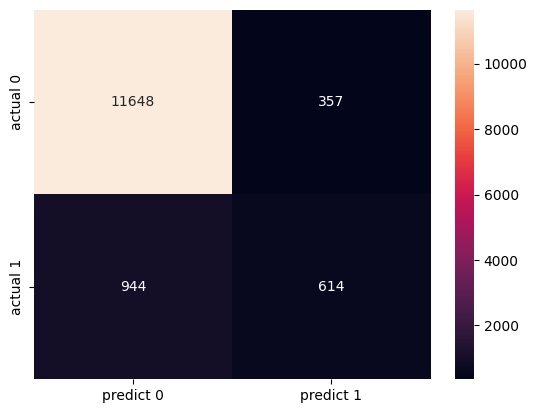

In [50]:
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(x_train, y_train)
rfcpred = rfc.predict(x_test)
cm=confusion_matrix(y_test, rfcpred)
print(cm)
print(round(accuracy_score(y_test, rfcpred),2)*100)
sns.heatmap(cm,annot=True,fmt='g',yticklabels=['actual 0','actual 1'],xticklabels=['predict 0','predict 1'])

In [51]:
#classification Metrics
RFCCV_Recall=recall_score(y_test,rfcpred)
RFCCV_F1=f1_score(y_test,rfcpred)
RFCCV_Pre=precision_score(y_test,rfcpred)
RFCCV = (cross_val_score(rfc,x_train,y_train,cv=k_fold,n_jobs=1, scoring='accuracy').mean())

###Ensemble Learning - Bagging

In [52]:
bgcl = BaggingClassifier(estimator=dtree, n_estimators=200, random_state=1)
bgcl = bgcl.fit(x_train, y_train)

0.898252598982526
Akurasi skor nya adalah 90.0
[[11484   521]
 [  859   699]]


<Axes: >

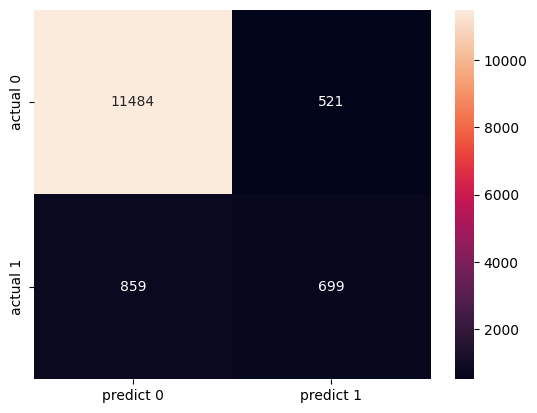

In [53]:
y_pred = bgcl.predict(x_test)
print(bgcl.score(x_test, y_test))
print("Akurasi skor nya adalah", round(accuracy_score(y_test, y_pred),2)*100)
cm=confusion_matrix(y_test, y_pred)
print(cm)
sns.heatmap(cm,annot=True,fmt='g',yticklabels=['actual 0','actual 1'],xticklabels=['predict 0','predict 1'])

In [54]:
#Classification Metrics
BAGCV= (cross_val_score(bgcl,x_train,y_train,cv=k_fold,n_jobs=1,scoring='accuracy').mean())
BAGCV_Recall=recall_score(y_test,y_pred)
BAGCV_Pre=precision_score(y_test,y_pred)
BAGCV_F1=f1_score(y_test,y_pred)

###Ensemble Learning - AdaBoosting

In [55]:
abcl = AdaBoostClassifier(n_estimators=200, random_state=1)
abcl = abcl.fit(x_train, y_train)

0.9015704490157045
[[11687   318]
 [ 1017   541]]


<Axes: >

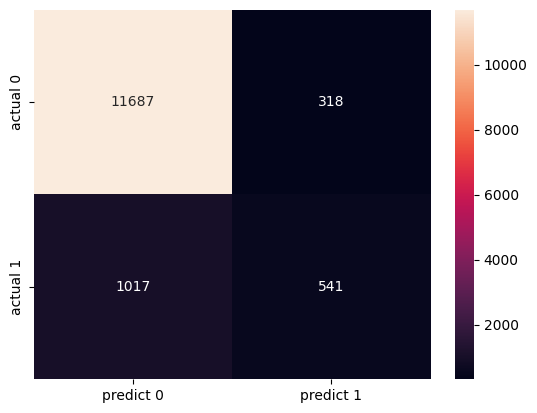

In [56]:
y_pred = abcl.predict(x_test)
print(abcl.score(x_test, y_test))

cm=confusion_matrix(y_test, y_pred)
print(cm)
sns.heatmap(cm,annot=True,fmt='g',yticklabels=['actual 0','actual 1'],xticklabels=['predict 0','predict 1'])

In [57]:
ADACV = (cross_val_score(abcl,x_train,y_train,cv=k_fold,n_jobs=1, scoring='accuracy').mean())
ADACV_Recall=recall_score(y_test,y_pred)
ADACV_F1=f1_score(y_test,y_pred)
ADACV_Pre=precision_score(y_test,y_pred)

###Ensemble Learning - GradientBoost

[[11677   328]
 [  964   594]]
90.0


<Axes: >

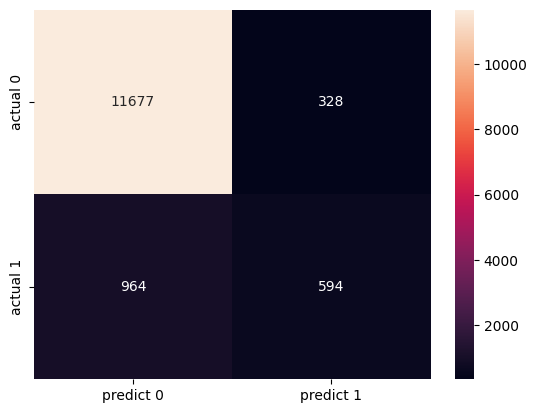

In [58]:
gbk = GradientBoostingClassifier()
gbk.fit(x_train, y_train)
gbkpred = gbk.predict(x_test)
cm=confusion_matrix(y_test, gbkpred)
print(cm)
print(round(accuracy_score(y_test, gbkpred),2)*100)
sns.heatmap(cm,annot=True,fmt='g',yticklabels=['actual 0','actual 1'],xticklabels=['predict 0', 'predict 1'])


In [59]:
#classification Metrics
GBCV = (cross_val_score(gbk,x_train,y_train, cv=k_fold, n_jobs=1, scoring='accuracy').mean())
GBCV_Recall=recall_score(y_test,gbkpred)
GBCV_F1=f1_score(y_test,gbkpred)
GBCV_Pre=precision_score(y_test,gbkpred)

####Mari kita komparasi performa semua models menggunakan multiple evaluation metrics for classification

In [60]:
#Cross value score
models = pd.DataFrame({
    'Models' : ['Decision Tree', 'Random Forest', 'Bagging', 'AdaBoost', 'GradientBoost'],
    'CV Score' : [DTREECV, RFCCV, BAGCV, ADACV, GBCV]})
models.sort_values(by='CV Score', ascending=False)


,Models,CV Score
4,GradientBoost,0.903903
1,Random Forest,0.901564
2,Bagging,0.898942
3,AdaBoost,0.898847
0,Decision Tree,0.869774


In [61]:
#Precision value score
models = pd.DataFrame({
    'Models' : ['Decision Tree', 'Random Forest', 'Bagging', 'AdaBoost', 'GradientBoost'],
    'CV Score' : [DTREECV_Pre, RFCCV_Pre, BAGCV_Pre, ADACV_Pre, GBCV_Pre]})
models.sort_values(by='CV Score', ascending=False)

,Models,CV Score
4,GradientBoost,0.644252
1,Random Forest,0.632338
3,AdaBoost,0.629802
2,Bagging,0.572951
0,Decision Tree,0.448780


In [62]:
#F1 Score
models = pd.DataFrame({
    'Models' : ['Decision Tree', 'Random Forest', 'Bagging', 'AdaBoost', 'GradientBoost'],
    'CV Score' : [DTREECV_F1, RFCCV_F1, BAGCV_F1, ADACV_F1, GBCV_F1]})
models.sort_values(by='CV Score', ascending=False)

,Models,CV Score
2,Bagging,0.503240
1,Random Forest,0.485567
4,GradientBoost,0.479032
0,Decision Tree,0.460288
3,AdaBoost,0.447662


In [63]:
#Recall Score
models = pd.DataFrame({
    'Models' : ['Decision Tree', 'Random Forest', 'Bagging', 'AdaBoost', 'GradientBoost'],
    'CV Score' : [DTREECV_Recall, RFCCV_Recall, BAGCV_Recall, ADACV_Recall, GBCV_Recall]})
models.sort_values(by='CV Score', ascending=False)

,Models,CV Score
0,Decision Tree,0.472401
2,Bagging,0.448652
1,Random Forest,0.394095
4,GradientBoost,0.381258
3,AdaBoost,0.347240


Di sini kita memiliki class imbalance  dan terdapat banyak 'no', sehingga recall akan menjadi measure kinerja yang bagus, dan tujuan kita adalah untuk memprediksi apakah klien akan berlangganan (ya/tidak) untuk melakukan deposito berjangka, sehingga tujuan kita adalah untuk mendapatkan sebanyak mungkin pelanggan meskipun kita tidak terlalu yakin.

##Oleh karena itu, berdasarkan score recall, Bagging dan Decision Tree Classifier berkinerja terbaik dalam kasus ini dan urutannya seperti di atas.

###Rekomendasi dan kesimpulan



*   Model terbaik: Decission Tree.
*   Recall cukup baik-> efektif untuk menyaring nasabah yang berpotensi untuk melakukan deposit berjangka.
*   Rekomendasi:


    *   Membuat kebijakan baru yang mendorong setiap nasabah untuk mengisi semua data yang diperlukan kedepannya.
    *   Menambahkan fitur2 atau kolom2 baru yang kemungkinan bisa berhubungan dengan campaign.
    *   Menganalisa data-data yang model kita masih salah tebak untuk mengetahui alasannya dan karakteristiknya bagaimana.





In [64]:
import pickle
with open("bank_model.pkl", "wb") as f:
    pickle.dump(bgcl, f)
print("model saved")

model saved
